# Spectral Subgraph Localization

**Author**: Amit Boyarski

## Intro

We are interested in solving the problem of **subgraph localization**:

Given a full graph $\mathcal{G}$ and a subgraph $\mathcal{H}$, find a subgraph (i.e., a set of nodes and edges) within $\mathcal{G}$ that matches $\mathcal{H}$ as close as possible.

The desired output is a scalar field over $\mathcal{G}$ denoting the probabilities of each node and edge belonging to $\mathcal{H}$. Note that this is a superficially simpler problem than finding full point-to-point correspondence between $\mathcal{H}$ and $\mathcal{G}$.

We approach the problem by modeling it as an optimization problem over $\mathcal{G}$. Let use denote by $\mathbf{v} : \mathcal{N}\rightarrow \mathbb{R}^{\mathcal{N}}$ and $\mathbf{E}: {\mathcal{N} \times \mathcal{N}}\rightarrow \mathbb{R}^{\mathcal{N} \times \mathcal{N}}$ two potential fields (i.e., "masks") over the nodes and edges of $\mathcal{G}$. We shall denote the Laplacian of $\mathcal{G}$ by $\mathbf{L} = \mathbf{D}-\mathbf{A}$, where $\mathbf{A}$ is the adjacency matrix, and $\mathbf{D}\equiv \textbf{diag}(\mathbf{A}\mathbf{1})$ is the degree matrix of $\mathcal{G}$.

The edge potential $\mathbf{E}$ is used to detach the subgraph from the full graph, i.e., by demanding $\mathbf{L}_E \equiv \mathbf{L}+\mathbf{E}$ to be a Laplacian of a graph composed of two disconnected components (one of which corresponds to $\mathcal{H}$). Once the subgraph has been detached, we use the node potential $\mathbf{v}$ to modify the spectrum of the edited Laplacian $\mathbf{L}_E$ such that it should match the spectrum of the Laplacian of $\mathcal{H}$, denoted hereby by $\mathbf{\lambda}_{ref}$.

To that end, our optimization problem is composed of a data term and regularization terms:


$$
\min_{\mathbf{E},\mathbf{v}} \mu_{spect}\|\mathbf{\lambda}(\mathbf{L}+\mathbf{E}+\text{diag}(\mathbf{v})) - \mathbf{\lambda}_{ref}\|^2 +
 \mu_{MS} \mathbf{v}^T\bigl( \mathbf{L}+\mathbf{E}\bigr) \mathbf{v} +\mu_{sparse} \|\mathbf{E}\|_{2,1}
$$
$$
\text{s.t.}\;\;\|\mathbf{v}\| = \text{const}, \mathbf{E}=\mathbf{E}^\top,\mathbf{E}\mathbf{1}=\mathbf{0},\;\text{offdiag}(\mathbf{L}+\mathbf{E})\leq 0,\;\text{tr}(\mathbf{E}) \leq k
$$


- The first term (spectral alignment term) is supposed to align the spectra of the localized subgraph with that of the reference subgraph $\mathcal{H}$.
- The second term penalizes the second eigenvalue of the edited Laplacian, thus enforcing the edited graph to have disconnected components.
- The third term is supposed to restrict the number of detached edges, e.g., by making the edge potential matrix sparse.
- The fourth term is in order to make sure that $\mathbf{v}$ is piecewise constant, i.e., it should equal $\infty$ (or some large number, larger than the maximum eugenvalue in $\mathbf{\lambda}_{ref}$) outside our subgraph, and $0$ on the subgraph. Alternatively, it pushes $\mathbf{v}$ into the nullspace of the edited Laplacian.
- The constraints ensure that $\mathbf{L}_E$ is a valid Laplacian, and that the number of edited edges is bounded by $k$.

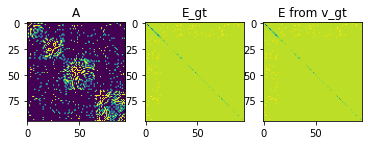

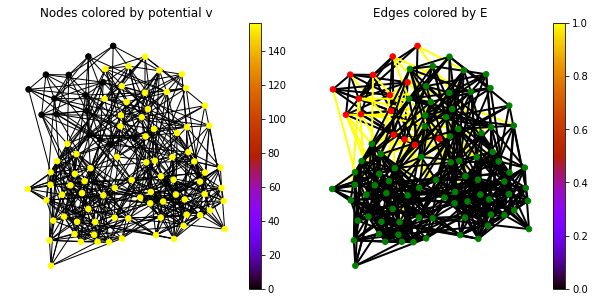

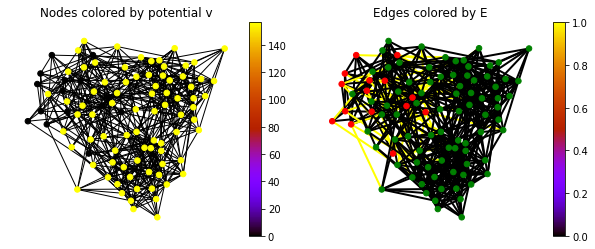

In [6]:
import kmeans1d as kmeans1d

from optimization.prox.prox import ProxNonNeg, ProxL21ForSymmCentdMatrixAndInequality, ProxL1ForSymmCentdMatrixAndInequality

from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from problem.spectral_subgraph_localization import block_stochastic_graph, SubgraphIsomorphismSolver

#torch.manual_seed(12)

sizes = [15, 20, 30, 30]
probs = 0.35 * np.eye(len(sizes))
for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        if i != j:
            probs[i, j] = 0.05
probs = probs.tolist()
G = nx.stochastic_block_model(sizes, probs, seed=42)
A = torch.tensor(nx.to_numpy_matrix(G))
n1 = sizes[0]
n = np.sum(sizes)


D = torch.diag(A.sum(dim=1))
L = D - A

A_sub = A[0:n1, 0:n1]
D_sub = torch.diag(A_sub.sum(dim=1))
L_sub = D_sub - A_sub
ref_spectrum = torch.linalg.eigvalsh(L_sub)

v_scale = float(n1 * np.max(ref_spectrum.numpy()))
v_gt = v_scale * np.ones(n)
v_gt[0:n1] = 0.0
A_edit = torch.zeros_like(A)
A_edit[0:n1, n1:n] = -A[0:n1, n1:n]
A_edit[n1:n, 0:n1] = -A[n1:n, 0:n1]
E_gt = torch.diag(A_edit.sum(axis=1)) - A_edit
E_from_v,_  = SubgraphIsomorphismSolver.E_from_v(torch.tensor(v_gt), A)

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flat
axes[0].imshow(A)
axes[0].set_title('A')
axes[1].imshow(E_gt)
axes[1].set_title('E_gt')
axes[2].imshow(E_from_v)
axes[2].set_title('E from v_gt')
plt.show()

SubgraphIsomorphismSolver.plot_on_graph(A=A.numpy().astype(int),
                                        n_subgraph=n1,
                                        v=v_gt,
                                        E=E_gt.numpy().astype(int))
SubgraphIsomorphismSolver.plot_on_graph(A=A.numpy().astype(int),
                                        n_subgraph=n1,
                                        v=v_gt,
                                        E=E_from_v.numpy().astype(int))

In [7]:
from optimization.prox.prox import ProxId, ProxSphere, ProxL21ForSymmetricCenteredMatrix

problem_params = {'mu_spectral': 1,
                  'mu_l21': 0,
                  'mu_MS': 0,
                  'mu_split': 0,
                  'mu_trace': 0.0,
                  'trace_val': 0
                  }
solver_params = {'lr': 0.002,
                 'v_prox': ProxSphere(radius=v_scale),
                 #'v_prox': ProxId(),
                 'E_prox': ProxL21ForSymmetricCenteredMatrix(solver="cvx"),
                 # 'E_prox': ProxL1ForSymmCentdMatrixAndInequality(solver="cvx", L=L,
                 #                                                 trace_upper_bound=
                 #                                                 1.1 * torch.trace(L)),}
                 'train_v': True,
                 'train_E': False
                 }
subgraph_isomorphism_solver = SubgraphIsomorphismSolver(A, ref_spectrum, problem_params, solver_params)

#subgraph_isomorphism_solver.set_init(v0=v_scale * torch.ones(n, dtype=torch.float64))
#subgraph_isomorphism_solver.set_init(v0=v_scale * torch.rand(n, dtype=torch.float64))


#subgraph_isomorphism_solver.set_init(E0=torch.tensor(E_gt))
#subgraph_isomorphism_solver.set_init(E0 = torch.tensor(E_gt), v0 = torch.tensor(v_gt))

# subgraph_isomorphism_solver.set_init(
#     v0 = torch.tensor(v_gt+0.5*v_scale*np.random.randn(v_gt.shape[0])))


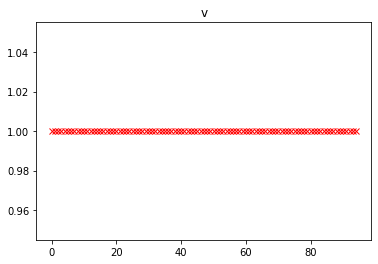

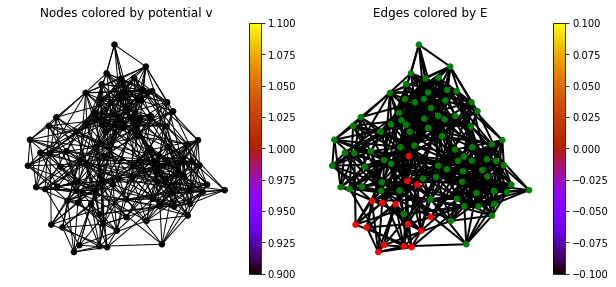

In [8]:
# plot init
v0 = subgraph_isomorphism_solver.v
E0 = subgraph_isomorphism_solver.E
plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': False,
    'individual loss terms': False}

subgraph_isomorphism_solver.plot(plots)
subgraph_isomorphism_solver.plot_on_graph(A=A.numpy().astype(int),
                                          n_subgraph=n1,
                                          v=v0.detach().numpy(),
                                          E=E0.detach().numpy())

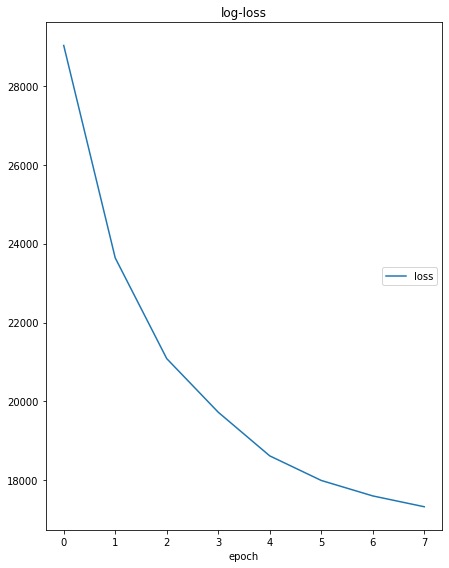

 16%|█▌        | 80/500 [00:01<00:06, 69.20it/s]

In [ ]:
from matplotlib.pyplot import pause
from metrics.evaluation_metrics import MetricEvaluator

metric_evaluator = MetricEvaluator(A)

plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': False}
v_acc_list = []
E_acc_list = []
v_balanced_acc_list = []
E_balanced_acc_list = []
metrics = []

mu_spectral_list = np.linspace(10,1,10)
for mu_spectral in mu_spectral_list:
    problem_params = {'mu_spectral': mu_spectral,
                      'mu_l21': 0,
                      'mu_MS': 1,
                      'mu_split': 0,
                      'mu_trace': 0.0,
                      'trace_val': 0
                      }
    subgraph_isomorphism_solver.set_problem_params(problem_params)
    v, E = \
        subgraph_isomorphism_solver.solve(max_outer_iters=1,max_inner_iters=500, show_iter=10, verbose=False)
    pause(1)
    subgraph_isomorphism_solver.plot(plots)
    subgraph_isomorphism_solver.plot_on_graph(A=A.numpy().astype(int),
                                              n_subgraph=n1,
                                              v=v.detach().numpy(),
                                              E=E.detach().numpy())

    metrics.append(metric_evaluator.evaluate(v_np = v.detach().numpy(),
                                         v_gt = v_gt))


    # v_np = v.detach().numpy()
    # E_np = E.detach().numpy()
    # v_ = v_np - np.min(v_np)
    # v_ = v_ / np.max(v_)
    # v_clustered, centroids = kmeans1d.cluster(v_, k=2)
    # v_clustered = torch.tensor(v_clustered,dtype = torch.float64)
    # E_clustered = subgraph_isomorphism_solver.E_from_v(v_clustered,A)
    # subgraph_isomorphism_solver.set_init(E0 = E_clustered,
    #                                      v0 = v_clustered)

# v, E = subgraph_isomorphism_solver.solve(maxiter=1000, show_iter=10, verbose=False)


metric_evaluator.print(metrics)

In [ ]:
import kmeans1d

plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': True}

v_np = v.detach().numpy()
E_np = E.detach().numpy()
v_ = v_np - np.min(v_np)
v_ = v_ / np.max(v_)
v_clustered, centroids = kmeans1d.cluster(v_, k=2)
t = 0.5 * (np.min(v_np) + np.max(v_np))
E_clustered = subgraph_isomorphism_solver.E_from_v(torch.tensor(v_clustered),A)

subgraph_isomorphism_solver.plot(plots)
subgraph_isomorphism_solver.plot_on_graph(A=A.numpy().astype(int),
                                          n_subgraph=n1,
                                          v=v_np,
                                          E=E_np)

subgraph_isomorphism_solver.plot_on_graph(A=A.numpy().astype(int),
                                          n_subgraph=n1,
                                          v=v_clustered,
                                          E=E_clustered.numpy())

In [ ]:
from sklearn.metrics import accuracy_score

v_ = v_gt.astype(int) - np.min(v_gt.astype(int))
v_ = v_ / np.max(v_)

E_clustered

metric_evaluator.accuracy(v_np = v.detach().numpy(),
                          v_gt = v_gt,
                          E_np=E.detach.nunmpy(),
                          E_gt=E_gt)

